## 목표 
---
1. U-Net, U-Net++ 모델 구현
2. KITTI 데이터셋을 상기 모델에 넣어 Segmentation 진행
3. 각 모델의 Segmentation 결과 시각화 및 IoU 계산치 비교

## U-Net과 U-Net ++이란?

### U-Net
---
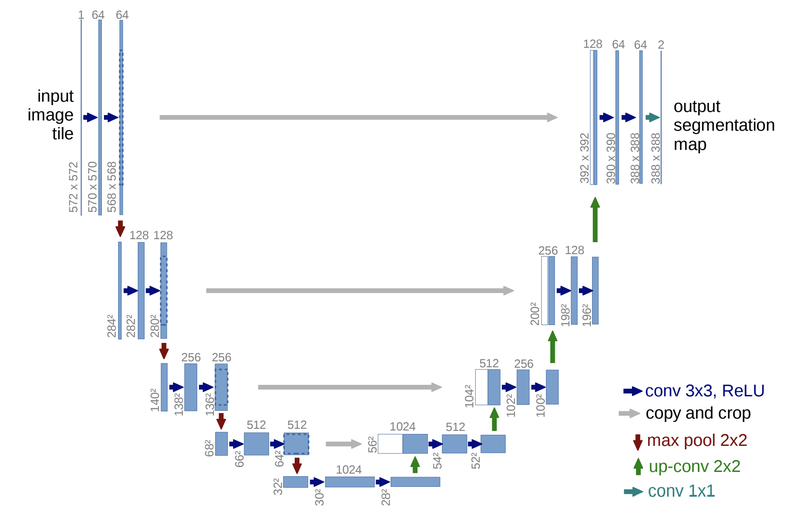


### U-Net ++
---
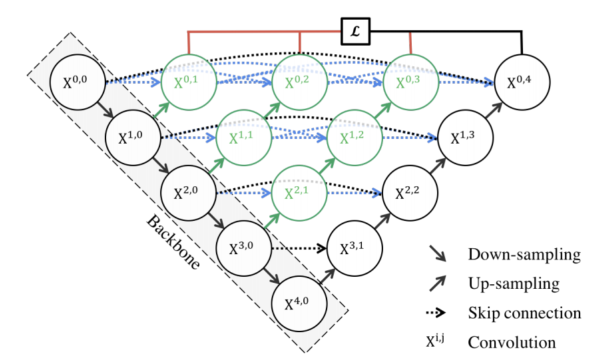

이번 실습의 컨셉은 Semantic Segmentation(시맨틱 세그멘테이션)을 이용해서 자율주행차량이 주행해야 할 도로 영역을 찾는 컨셉으로 하여 도로 영역을 Segmentation할 수 있도록 모델을 만들어 보겠습니다!

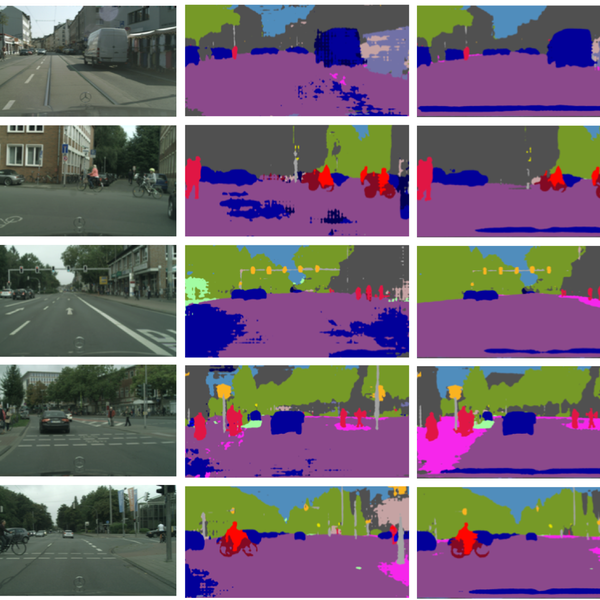

## STEP 0. 라이브러리 로드
---

In [14]:
import os
import math
import numpy as np
import tensorflow as tf

import skimage
from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

from albumentations import  *

In [17]:
! pip install albumentations

## STEP1. KITTI 데이터셋 구축
---
Segmentation을 위한 모델을 학습시키려면 도로와 물체의 영역이 라벨링 된 데이터를 가지고 학습할 수 있도록 파싱해야합니다. 따라서 segmentation이 잘 되어있는 KITTI의 데이터셋을 사용해봅니다. 

다운로드한 KITTI Segmentation 데이터에 data augmentation을 적용하여 데이터셋을 구축합니다. 

data augmentation은 albumentation으로 사용하며 실제 도로에서 일어날 수 있는 경우로 구축해줍니다.  

#### KITTI data sets
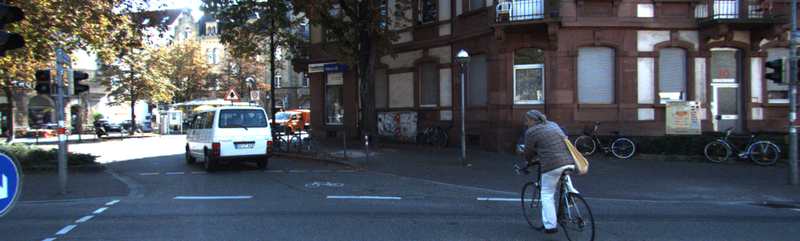
[KITTI 도로 사진]
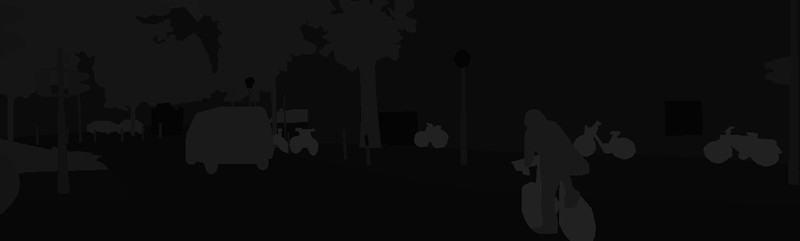
[segmentation]
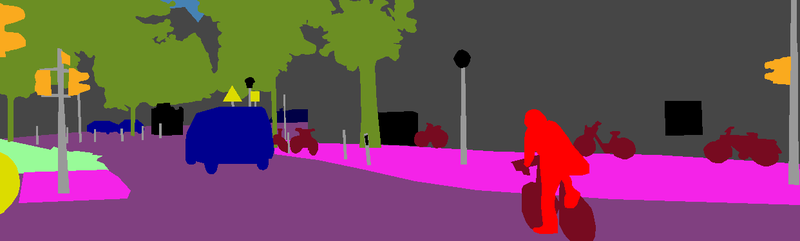
[segmentation_rgb]

이렇게 데이터셋을 구성해주다니 KITTI 좋네요...ㅎㅎ




#### albumentation 참고자료
- Keras Sequence에 기반한 Dataloader(https://hwiyong.tistory.com/241)
- Albumentation을 적용한 Keras sequence(https://medium.com/the-artificial-impostor/custom-image-augmentation-with-keras-70595b01aeac)
- 직접 적용 바로 보기 (https://albumentations-demo.herokuapp.com/)

In [22]:
def build_augmentation(is_train = True):
    if (is_train):
        return Compose([HorizontalFlip(p=0.5),
                        RandomContrast(limit=0.2, p=0.5),
                        RandomGamma(gamma_limit=(80, 120), p=0.5),
                        RandomBrightness(limit=0.2, p=0.5),
                        RandomSizedCrop(min_max_height=(300, 370),
                                 w2h_ratio=370/1242,
                                 height=224,
                                 width=224,
                                 p=0.5),
                        HueSaturationValue(hue_shift_limit=5, 
                                    sat_shift_limit=20,
                                    val_shift_limit=10, 
                                    p=.9),
                        Resize(width=224,height=224)
                        ])
    else:
        return Compose([
                        Resize(width=224,height=224)
                        ])

In [12]:
dir_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/data/training'

In [23]:
augmentation_train = build_augmentation()
augmentation_test = build_augmentation(is_train = False)
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

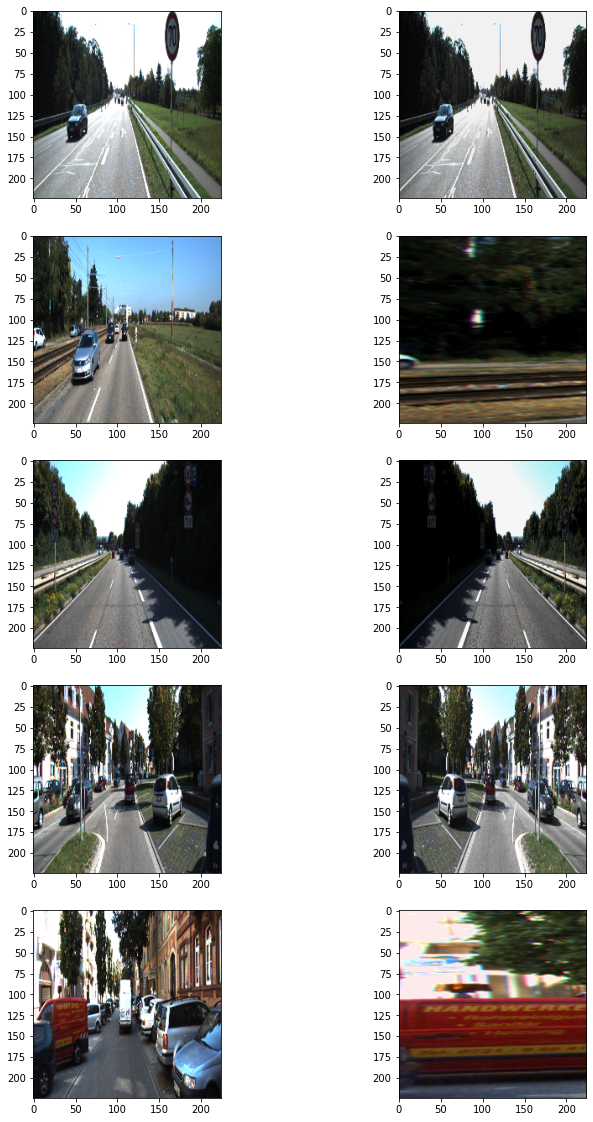

In [27]:
# augmentation 적용 확인
plt.figure(figsize = (12,20))
for i in range(5):
    image = imread(input_images[i])
    image_data = {'image':image}
    resized = augmentation_test(**image_data)
    processed = augmentation_train(**image_data)
    plt.subplot(5, 2, 2*i + 1)
    plt.imshow(resized['image'])
    plt.subplot(5, 2, 2*i + 2)
    plt.imshow(processed['image'])

plt.show()

잘 작동하는 것을 확인했으니 이대로 데이터셋을 구성해봅니다! 

이번엔 새로 배운 `tf.keras.utils.Sequence`를 상속받은 Generator 형태로 만들어 봅니다. 데이터를 원하는 형식으로 바꾸기 위해 Sequence를 커스텀하여 사용합니다. 

class내에 데이터 로드함수, batchsize만큼 불러오는 함수를 각각 설정해주는 형태입니다. 한 클래스 내에서 데이터 셋의 모든 것을 처리하니 문제 및 수정사항이 생겼을 때, 하나의 클래스내에서 해결하면 된다는 장점 있었습니다!

In [28]:
class KittiGenerator(tf.keras.utils.Sequence):
    def __init__(self, 
                dir_path,
                batch_size = 16,
                img_size = (224, 224, 3),
                output_size = (224,224),
                is_train = True,
                augmentation = None):
        
        self.dir_path = dir_path
        self.batch_size = batch_size
        self.img_size = img_size
        self.output_size = output_size
        self.is_train = is_train
        self.augmentation = augmentation    
        self.data = self.load_dataset()
        
    # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인
    def load_dataset(self):
        input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
        label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
        input_images.sort()
        label_images.sort()
        assert len(input_images) == len(label_images)
        data = [_ for _ in zip(input_images, label_images)]
        
        if self.is_train:
            return data[:-30]
        return data[-30:]
    
    # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환
    def __len__(self):
        return math.ceil(len(self.data) / self.batch_size)
    
    # image augmentation에 맞춰 semantic label에도 같이 적용 
    def __getitem__(self,index):
        batch_data = self.data[
            index * self.batch_size:
            (index + 1) * self.batch_size
        ]
        inputs = np.zeros([self.batch_size, *self.img_size])
        outputs = np.zeros([self.batch_size, *self.output_size])
        
        for i, data in enumerate(batch_data):
            input_img_path, output_path = data
            _input = imread(input_img_path)
            _output = imread(output_path)
            _output = (_output == 7).astype(np.uint8)*1
            data = {
                "image" : _input,
                "mask" : _output
            }
            augmentation = self.augmentation(**data)
            inputs[i] = augmentation["image"]/255
            outputs[i] = augmentation["mask"]
            return inputs, outputs
        
            # 한 epoch가 끝나면 학습중인 경우에 순서를 random shuffle하도록 적용
        def on_epoch_end(self):
            self.indexes = np.arange(len(self.data))
            if self.is_train == True:
                np.random.shuffle(self.indexes)
                return self.indexes

In [29]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train = False)

train_generator = KittiGenerator(dir_path,
                                augmentation = augmentation)

test_generator = KittiGenerator(dir_path,
                               augmentation = test_preproc,
                               is_train = False)

## Step 2. U-Net, U-Net++ 모델 구현
--- 
1. U-Net 모델 구현
2. U-Net 모델을 Backbone으로하여 U-Net++을 구현
3. 파라미터 변경 등을 통해 추가적인 성능 향상

### 1. U-Net 모델 구현
---
본 논문에서는 `padding`을 사용하지 않고 `crop`하여 `Concatenate`를 진행해주지만, 전 **`padding`을 사용하여 crop없이 concat하고, `Dropout`, `batchnormalization`을 적절히 사용**했습니다.

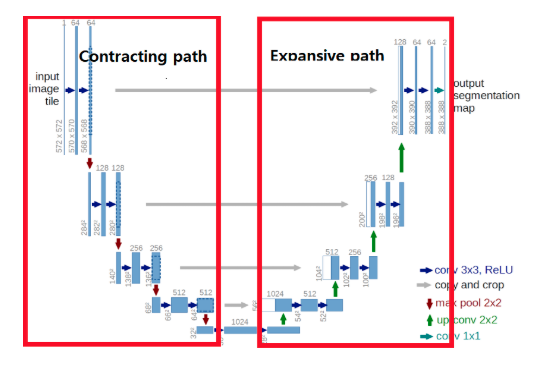

In [53]:
# 공통되는 conv2D block 설정
def conv2d_block(input_tensor, n_filters, kernel_size=3):
    x = input_tensor
    for i in range(2):
        x = Conv2D(filters=n_filters, kernel_size=kernel_size, kernel_initializer='he_normal', activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    return x

# upsampling에 사용되는 transpose2d
def transpose2d(input_tensor, n_filters):
    x = input_tensor
    x = Conv2DTranspose(filters = n_filters, kernel_size = 2, strides = (2, 2), activation='relu', kernel_initializer = 'he_normal')(x)
    return x 

In [54]:
def build_unet_model(input_shape= (224,224,3)):
    inputs = Input(input_shape)
    
    # Contracting Path (Encoder)
    conv1 = conv2d_block(inputs, 64)
    maxpooling1 = MaxPool2D(pool_size = (2, 2))(conv1)
    
    conv2 = conv2d_block(maxpooling1, 128)
    maxpooling2 = MaxPool2D(pool_size = (2, 2))(conv2)
    
    conv3 = conv2d_block(maxpooling2, 256)
    maxpooling3 = MaxPool2D(pool_size = (2, 2))(conv3)
    
    conv4 = conv2d_block(maxpooling3, 512)
    drop4 = Dropout(0.5)(conv4)
    maxpooling4 = MaxPool2D(pool_size = (2, 2))(drop4)
    
    # Bottle neck Part
    bottle_neck5 = conv2d_block(maxpooling4, 1024)
    
    # Expansive Path (Decoder)
    drop6 = Dropout(0.5)(bottle_neck5)
    up_conv6 = transpose2d(drop6, 512)
    concat6 = concatenate(inputs = [drop4, up_conv6], axis = 3)
    conv6 = conv2d_block(concat6, 512)
    
    up_conv7 = transpose2d(conv6, 256)
    concat7 = concatenate(inputs = [conv3, up_conv7], axis = 3)
    conv7 = conv2d_block(concat7, 256)
    
    up_conv8 = transpose2d(conv7,128)
    concat8 = concatenate(inputs = [conv2, up_conv8], axis = 3)
    conv8 = conv2d_block(concat8, 128)
    
    up_conv9 = transpose2d(conv8, 64)
    concat9 = concatenate(inputs = [conv1, up_conv9], axis = 3)
    conv9 = conv2d_block(concat9, 64)
    conv9 = Conv2D(filters = 2, kernel_size = 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)     
    
    # Prediction Part
    last_conv = Conv2D(filters = 1, kernel_size = 1, activation = 'sigmoid')(conv9)
    
    model = Model(inputs = inputs, outputs = last_conv)
    
    return model

In [55]:
model_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unet.h5'

UNet_model = build_unet_model()
UNet_model.compile(optimizer = Adam(1e-4), loss = 'binary_crossentropy')

UNet_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_80 (Conv2D)              (None, 224, 224, 64) 1792        input_8[0][0]                    
__________________________________________________________________________________________________
conv2d_81 (Conv2D)              (None, 224, 224, 64) 36928       conv2d_80[0][0]                  
__________________________________________________________________________________________________
batch_normalization_38 (BatchNo (None, 224, 224, 64) 256         conv2d_81[0][0]                  
____________________________________________________________________________________________

summary는 잘 나온 것 같고, model architecture도 한번 찍어줍니다.

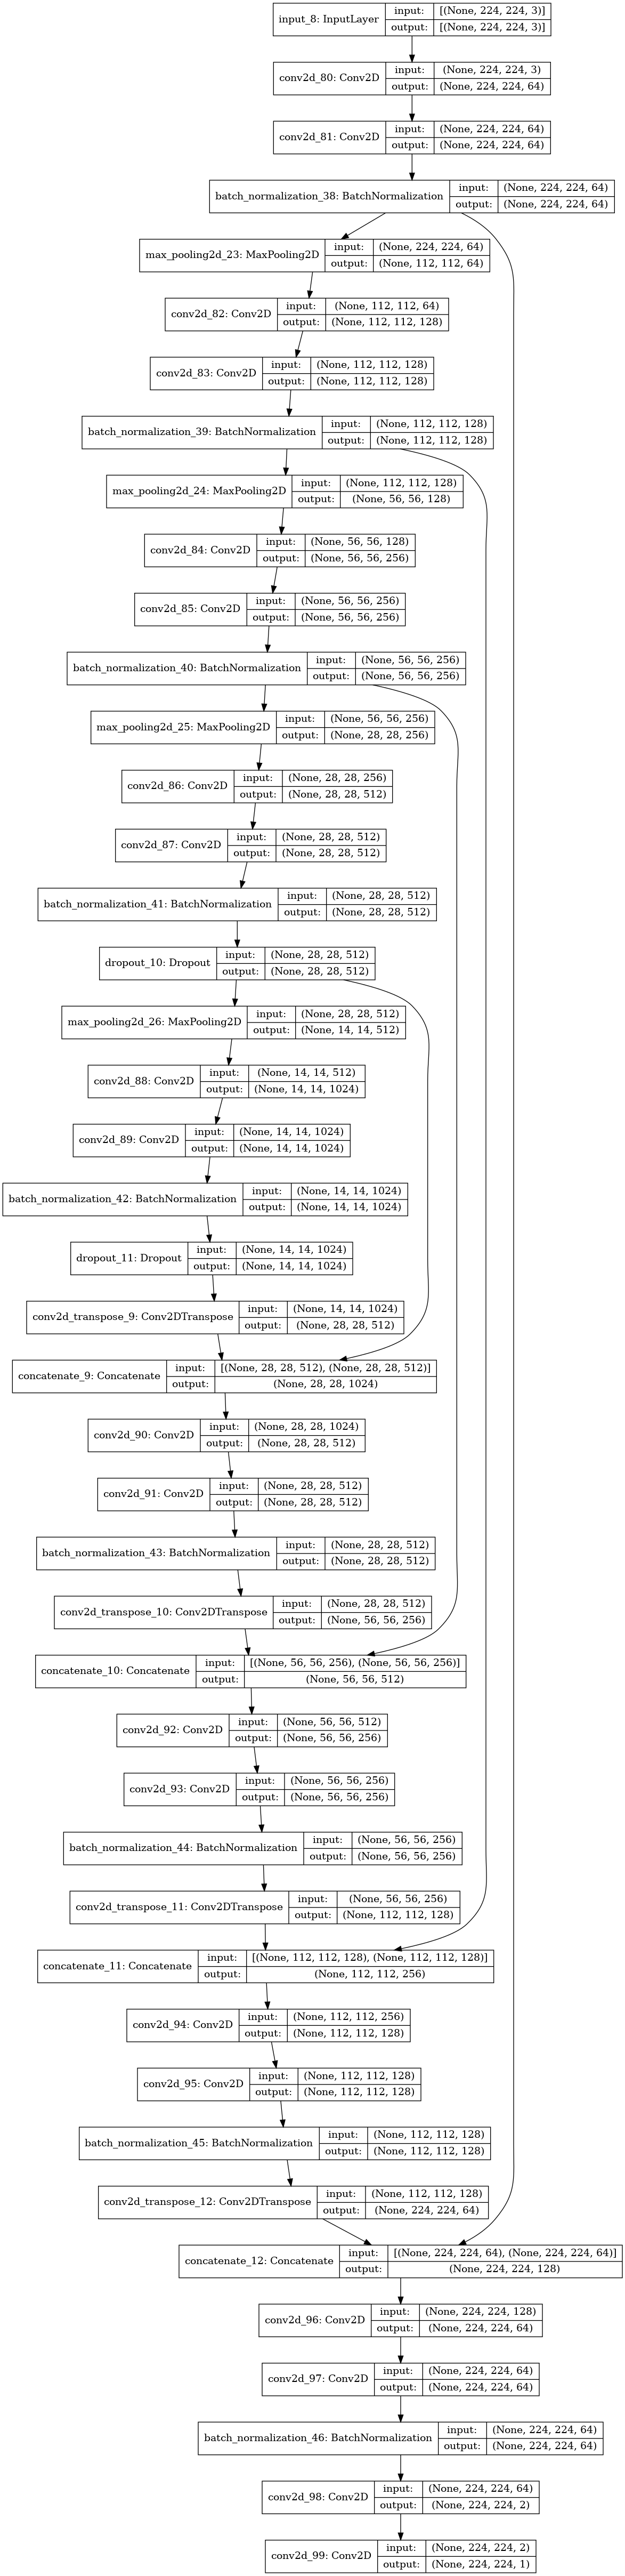

In [56]:
tf.keras.utils.plot_model(UNet_model, 'UNet_model.png', show_shapes = True)tf.keras.utils.plot_model(UNet_model, 'UNet_model.png', show_shapes = True)

깔끔하게 모델이 완성되었습니다:)! 뿌듯하네요ㅎㅎㅎ
이런 뿌듯함에 코딩하죠~~~~

생각해보니 저기에 `filter_num = [64,128,256,512,1024]`로 먼저 선언해주고 `filter_num[0]` 같은 형식으로 넣어주면 나중에 수정하기 편할 것 같네요.

이제 U-Net을 기준으로 U-Net++을 만들어봅시다.

### 2. U-Net++ 모델 구현
---

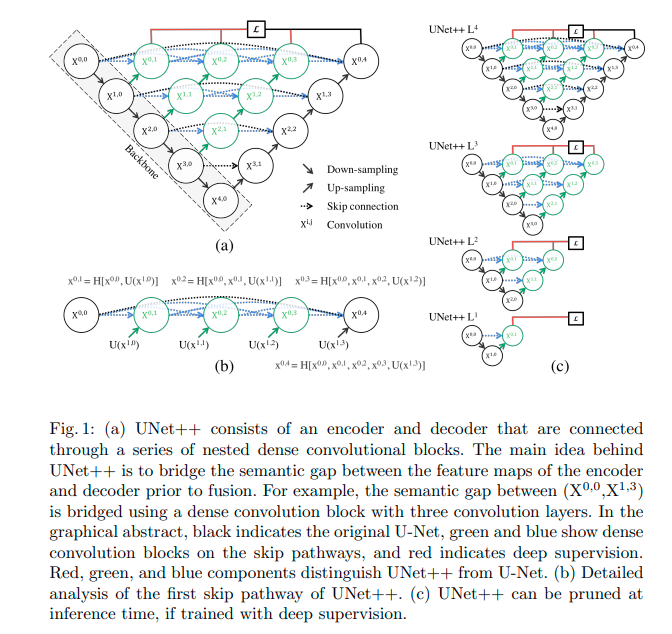

- [출처 : UNet++: A Nested U-Net Architecture for Medical Image Segmentation 논문](https://arxiv.org/pdf/1807.10165.pdf)

거의 Dense Net의 U-Net version처럼 느껴집니다...ㅎㅎㅎ.....  

겁먹지 말고 들어가봅시다!!

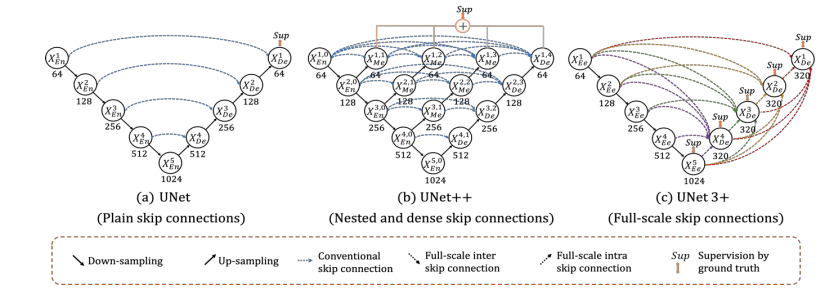

In [70]:
def build_unet_pp_model(input_shape= (224,224,3), deep_supervision = True):
    inputs = Input(input_shape)
    
    # Backbone
    X1_0 = conv2d_block(inputs, 64)
    maxpooling1 = MaxPool2D(pool_size = (2, 2))(X1_0)
    
    X2_0 = conv2d_block(maxpooling1, 128)
    maxpooling2 = MaxPool2D(pool_size = (2, 2))(X2_0)
    
    X3_0 = conv2d_block(maxpooling2, 256)
    maxpooling3 = MaxPool2D(pool_size = (2, 2))(X3_0)
    
    X4_0 = conv2d_block(maxpooling3, 512)
    drop4 = Dropout(0.5)(X4_0)
    maxpooling4 = MaxPool2D(pool_size = (2, 2))(drop4)
    
    # Bottle neck Part
    X5_0 = conv2d_block(maxpooling4, 1024)
    drop5 = Dropout(0.5)(X5_0)
    
    # Skip & Up sampling
    # X4_
    X4_1 = transpose2d(drop5, 512)
    X4_1 = concatenate([X4_1, drop4], axis = 3)
    X4_1 = conv2d_block(X4_1, 512)
    
    # X3_
    X3_1 = transpose2d(drop4, 256)
    X3_1 = concatenate([X3_1, X3_0], axis = 3)
    X3_1 = conv2d_block(X3_1, 256)
    
    X3_2 = transpose2d(X4_1, 256)
    X3_2 = concatenate([X3_2, X3_1, X3_0], axis = 3)
    X3_2 = conv2d_block(X3_2, 256)
    
    # X2_
    X2_1 = transpose2d(X3_0, 128)
    X2_1 = concatenate([X2_1, X2_0], axis = 3)
    X2_1 = conv2d_block(X2_1, 128)
    
    X2_2 = transpose2d(X3_1, 128)
    X2_2 = concatenate([X2_2, X2_1, X2_0], axis = 3)
    X2_2 = conv2d_block(X2_2, 128)
    
    X2_3 = transpose2d(X3_2, 128)
    X2_3 = concatenate([X2_3, X2_2, X2_1, X2_0], axis = 3)
    X2_3 = conv2d_block(X2_3, 128)

    #X1_
    X1_1 = transpose2d(X2_0, 64)
    X1_1 = concatenate([X1_1, X1_0], axis = 3)
    X1_1 = conv2d_block(X1_1, 64)
    
    X1_2 = transpose2d(X2_1, 64)
    X1_2 = concatenate([X1_2, X1_1, X1_0], axis = 3)
    X1_2 = conv2d_block(X1_2, 64)
    
    X1_3 = transpose2d(X2_2, 64)
    X1_3 = concatenate([X1_3, X1_2, X1_1, X1_0], axis = 3)
    X1_3 = conv2d_block(X1_3, 64)
    
    X1_4 = transpose2d(X2_3, 64)
    X1_4 = concatenate([X1_4, X1_3, X1_2, X1_1, X1_0], axis = 3)
    X1_4 = conv2d_block(X1_4, 64)
    
    kernel_regularizer_l2 = tf.keras.regularizers.L2(1e-4)
    
    # Prediction Part
    output1_1 = Conv2D(filters = 1, kernel_size = 1, activation = 'sigmoid', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=kernel_regularizer_l2)(X1_1)
    output1_2 = Conv2D(filters = 1, kernel_size = 1, activation = 'sigmoid', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=kernel_regularizer_l2)(X1_2)
    output1_3 = Conv2D(filters = 1, kernel_size = 1, activation = 'sigmoid', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=kernel_regularizer_l2)(X1_3)
    output1_4 = Conv2D(filters = 1, kernel_size = 1, activation = 'sigmoid', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=kernel_regularizer_l2)(X1_4)

    if (deep_supervision):
        output = (output1_1, output1_2, output1_3, output1_4)
        model = Model(inputs = inputs, outputs = output)
        return model
    else: 
        output = output1_4
        model = Model(inputs = inputs, outputs = output)
        return model

U-Net++ 모델은 완성되었습니다.
U-Net++ 의 특징 중 하나인 Deep Supervision은 모든 세그먼테이션 브랜치(segmentation branches)들로 부터 출력된 아웃풋의 평균화하는 정확한 모드나 nal 세그먼이션 맵이 세그멘테이션 브랜치 중 한 개를 선택하는 빠른모드로서, 그러한 선택은 모델 pruning정도와 속도 이득(gain)에 영향을 줍니다.

또한  U-Net++는 여러 시맨틱 레벨에서 전체 해상도 특성 맵을 생성한다. 따라서 loss를 4개의 시맨틱 레벨로 부터 예측하는 특징이 있습니다.

- 참고 블로그 https://engineer-mole.tistory.com/40?category=911427 [매일 꾸준히, 더 깊이:티스토리]

**이 Deep Supervision의 유무에 따라 값이 바뀌는지도 궁금하니 각각 모델을 만들어 비교해보도록 합니다!**

In [71]:
# deep_supervision False 모델

model_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unet_pp.h5'

UNet_PP_plain_model = build_unet_pp_model(deep_supervision = False)

UNet_PP_plain_model.compile(optimizer = Adam(1e-4), loss = 'binary_crossentropy')

UNet_PP_plain_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_284 (Conv2D)             (None, 224, 224, 64) 1792        input_15[0][0]                   
__________________________________________________________________________________________________
conv2d_285 (Conv2D)             (None, 224, 224, 64) 36928       conv2d_284[0][0]                 
__________________________________________________________________________________________________
batch_normalization_137 (BatchN (None, 224, 224, 64) 256         conv2d_285[0][0]                 
____________________________________________________________________________________________

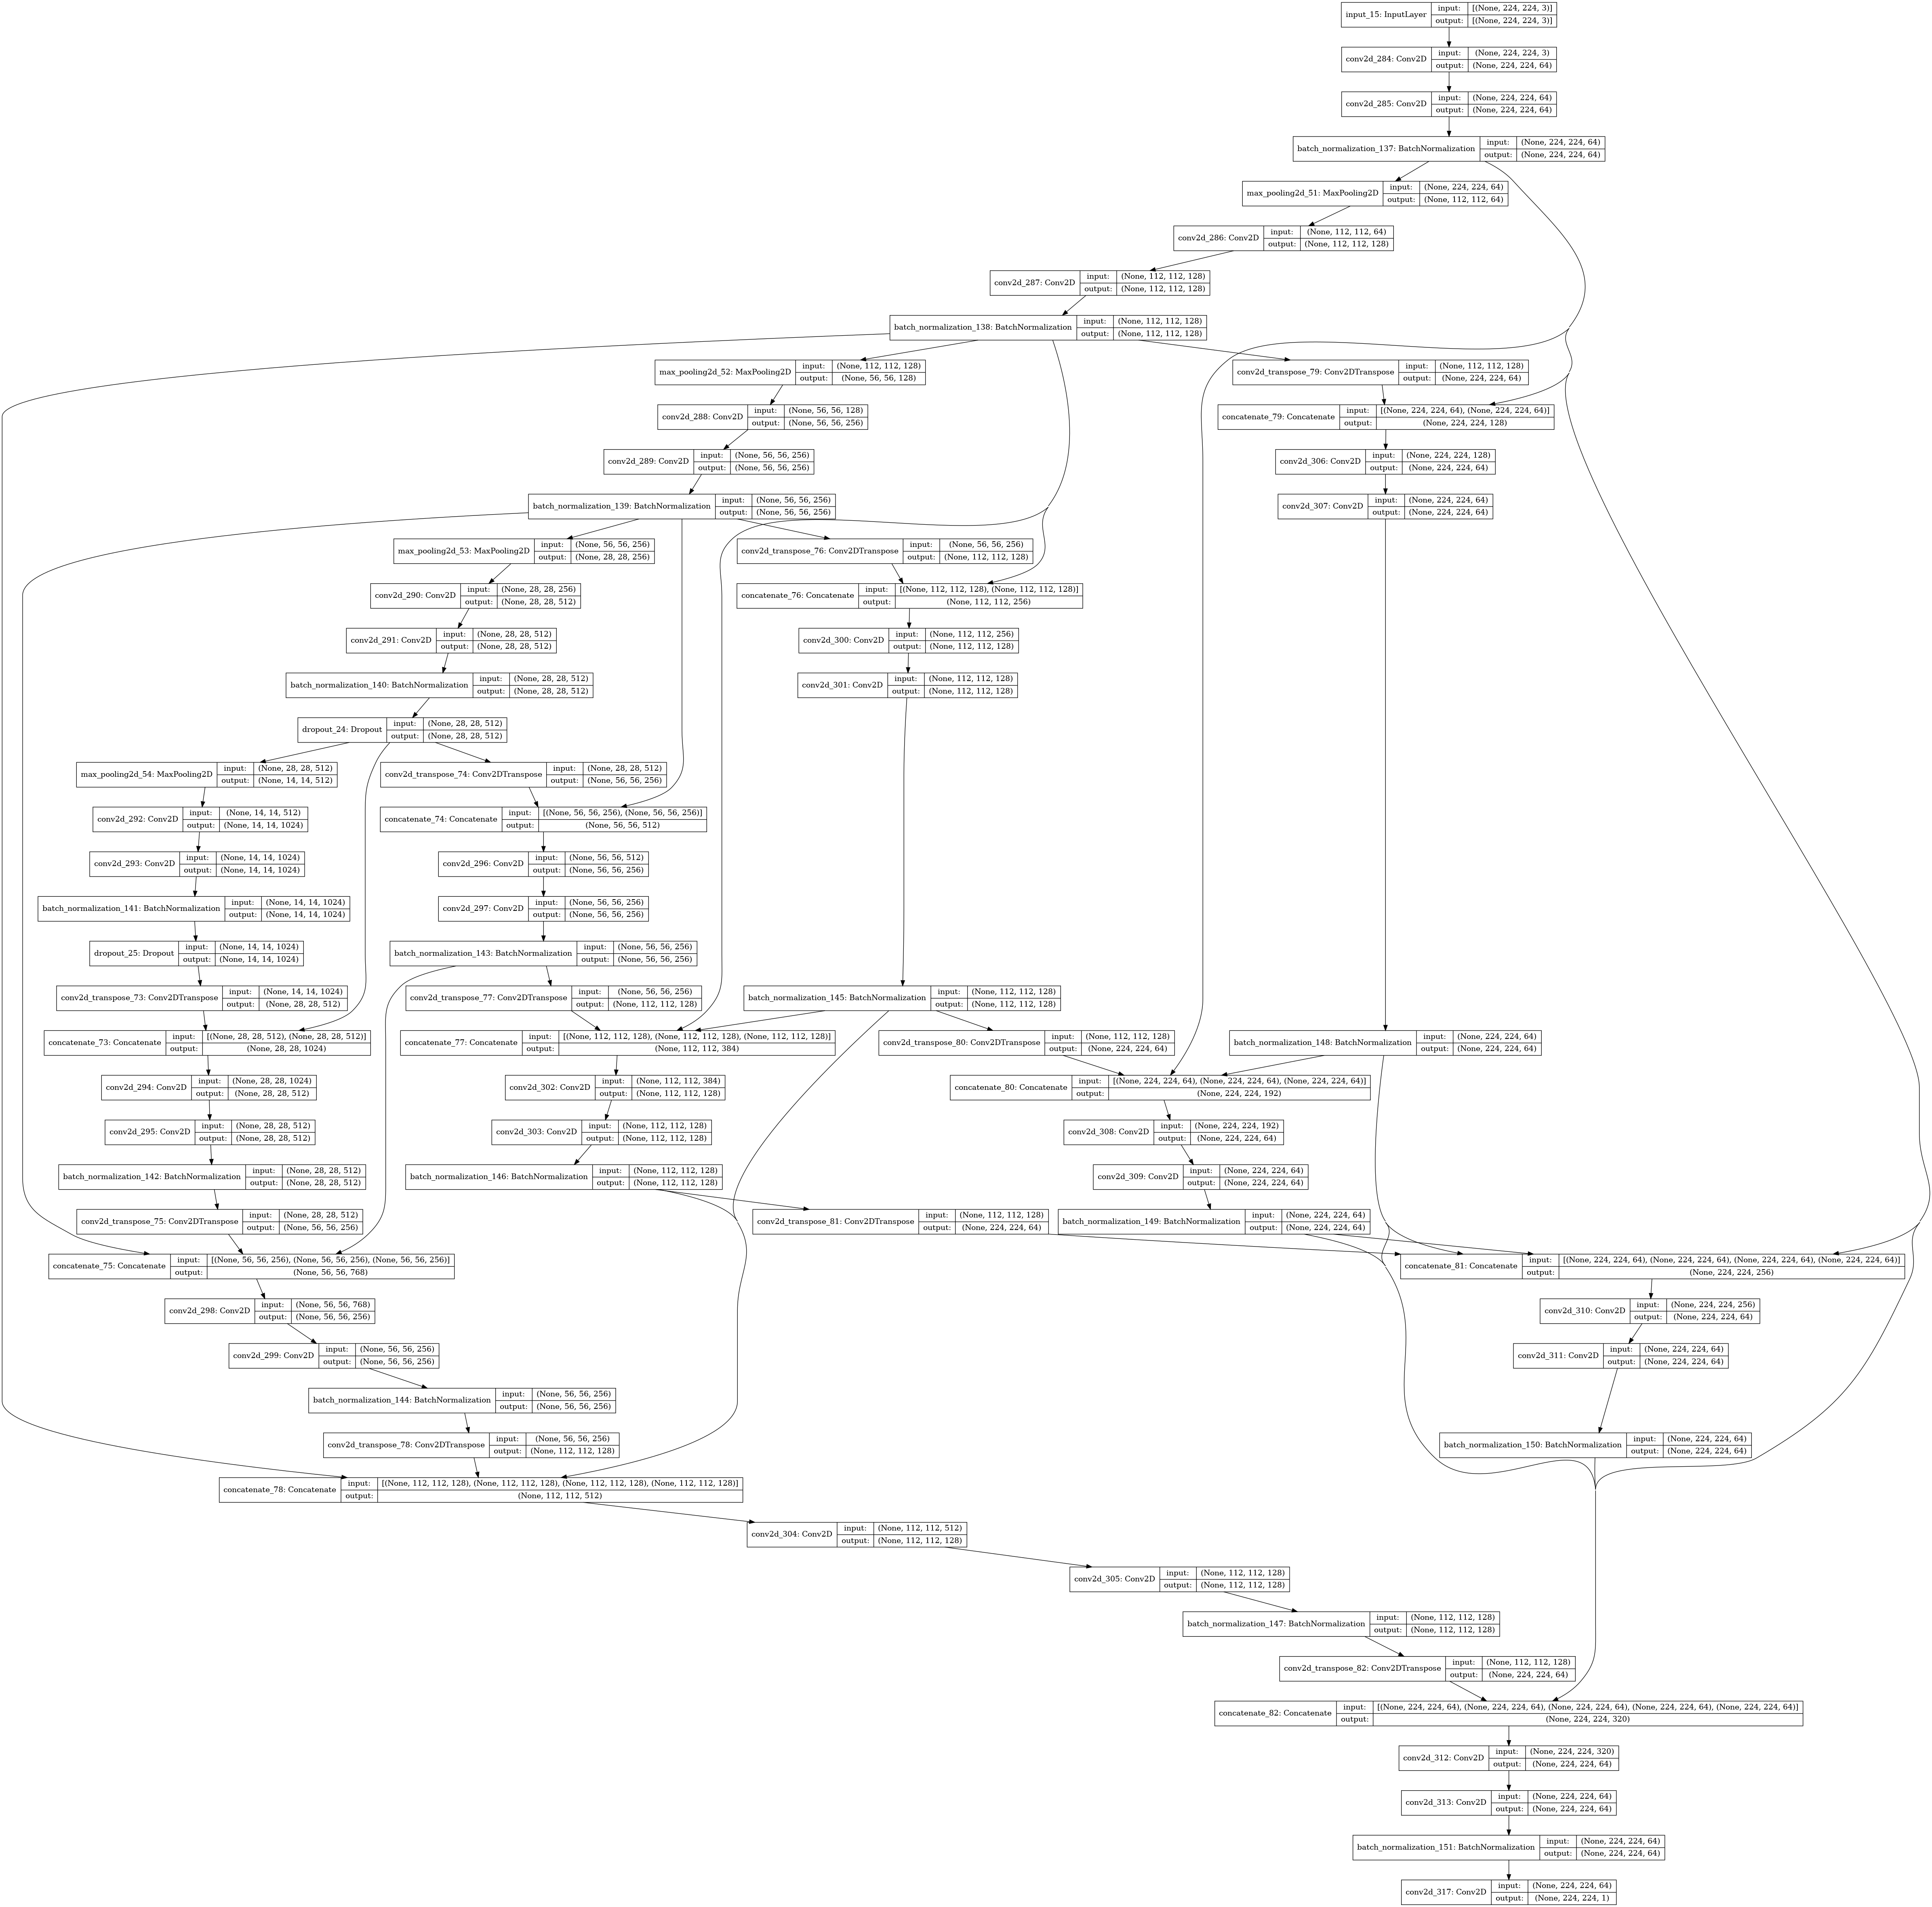

In [72]:
tf.keras.utils.plot_model(UNet_PP_plain_model, 'UNet_PP_plain_model.png', show_shapes = True)

ㅋㅋㅋ 아주그냥 온 동네방네 다 참견하는 모델이 완성되었습니다ㅋㅋㅋㅋ

그럼 deep supervision 모델을 만들기 위해 U-Net++의 특별한 loss함수를 설정해줍시다.

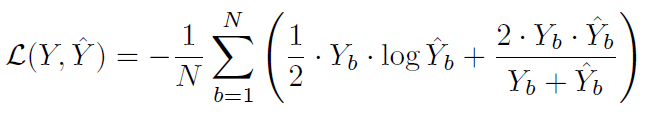
U-Net++의 loss 함수입니다. 

binary cross-entropy와 dice coefficient를 결합한 것을 사용합니다.

In [ ]:
def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1. - dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    return 0.5 * keras.losses.binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)

In [ ]:
# deep_supervision True 모델

model_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unet_pp_deep.h5'

UNet_PP_deep_model = build_unet_pp_model()

UNet_PP_deep_model.compile(optimizer="Adam", 
                           loss=dice_coef_loss, 
                           metrics=["binary_crossentropy", mean_iou, dice_coef])

UNet_PP_deep_model.summary()

In [ ]:
p_test = model.predict(x_test, batch_size=config.batch_size, verbose=config.verbose)
eva = model.evaluate(x_test, y_test, batch_size=config.batch_size, verbose=config.verbose)
